#  Integration with single cell and TCGA bulk data

If using an external R installation (may not be necessary on Linux systems).

In [1]:
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.1'

## import the packages

In [2]:
import os
import cytobulk as ct
import scanpy as sc
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Load scRNA-seq and bulk data

Load the reference single cell data, e.g. HTAN MSK data [[Download data]](https://drive.google.com/file/d/1TOd0SbSWGGsY-UAqVQ3fzGTJLR5yJowg/view?usp=sharing). and TCGA LUSC data  [[Download data]](https://drive.google.com/file/d/1wlEW4-s7xaiBB-dkn2szymE_6sIJLuyV/view?usp=drive_link).

In [ ]:
sc_adata = sc.read_h5ad("C:/Users/wangxueying/project/CytoBulk/case/TCGA_LUSC/input/sub_HTAN_MSK.h5ad")
sc_adata_ori = sc_adata.copy()
bulk_adata = sc.read_h5ad("C:/Users/wangxueying/project/CytoBulk/case/TCGA_LUSC/input/TCGA_LUSC.h5ad")

The cell type information is be stored in sc_adata.obs['he_cell_type']

In [4]:
sc_adata.obs['he_cell_type'].value_counts()

he_cell_type
epithelial           25988
lymphocytes           4535
connective tissue      565
neutrophils             69
plasma cells             8
Name: count, dtype: int64

## Deconvolute bulk data with sc-RNA seq as the reference.

If you want to use the pretrained model, please download the folder, extract it, and set the path of the extracted folder as the out_dir parameter. [[Download]](https://drive.google.com/file/d/1nBWmHgnZhaX1OeSehVaHeuZ2MXGNB8I_/view?usp=drive_link) This will help you skip the training steps.

In [7]:
deconv_result,deconv_adata = ct.tl.bulk_deconv(bulk_data = bulk_adata,
                                                sc_adata = sc_adata,
                                                annotation_key ="he_cell_type",
                                                out_dir=r"C:\Users\wangxueying\project\CytoBulk\case\TCGA_LUSC\TCGA_LUSC_2000",
                                                dataset_name="lusc",
                                                different_source=True,
                                                downsampling=True,
                                                n_cell=2000)

In [8]:
deconv_result.head(5)

,connective tissue,epithelial,lymphocytes,neutrophils,plasma cells
TCGA-18-3421,0.273443,0.176402,0.199808,0.204587,0.130384
TCGA-37-4133,0.282663,0.193125,0.156352,0.146849,0.171124
TCGA-L3-A524,0.337083,0.295797,0.119766,0.124372,0.121685
TCGA-56-A4ZK,0.322920,0.144941,0.182277,0.145558,0.146625
TCGA-39-5027,0.241746,0.491989,0.093591,0.133225,0.109625


## Mapping scRNA-seq to bulk data

If you want to use multithreading for mapping, you can set multiprocessing=True and specify the number of CPUs to use with the cpu_num parameter.

In [ ]:
reconstructed_cell, reconstructed_adata = ct.tl.bulk_mapping(bulk_adata = deconv_adata,
                                                            sc_adata = sc_adata,
                                                            out_dir="/data1/wangxueying/cytobulk/out/TCGA_LUSC_2000",
                                                            project="TCGA_LUSC",
                                                            n_cell=2000,
                                                            annotation_key='he_cell_type',
                                                            multiprocessing=False)
                

The matching relationship between single cells and bulk samples is stored in reconstructed_cell. The data assigned to the same bulk sample is aggregated, and the new expression values are stored in reconstructed_adata.layers['mapping_ori'], while the original expression values are stored in reconstructed_adata.X.


In [19]:
reconstructed_cell.head(5)

,sample_id,cell_id
0,TCGA-18-3421,RU426B_197057083469109
1,TCGA-18-3421,RU426B_135693665261491
2,TCGA-18-3421,RU1144_T_236768069871899
3,TCGA-18-3421,RU1311A_T_1_130539716504350
4,TCGA-18-3421,RU1195A_236107999337252


### Visulization of marker gene expression similarity between original and reconstructed data

Load the marker gene data across cell types. [[Download st data]](https://drive.google.com/file/d/1X_Bc4w-F5uNaZqhpf0AFsBMjpHEoOZY3/view?usp=drive_link)

In [7]:
marker_df = pd.read_csv(r"C:\Users\wangxueying\project\CytoBulk\case\bulk_brca\marker_gene_symbol.txt", sep="\t",index_col=0)

In [8]:
marker_df.head(5)

,score,pvalue,adj_pvalue,cell_type,ensg_id,gene_symbol
gene,,,,,,
ENSG00000142089,13.354671,5.980232e-32,1.183209e-30,connective tissue,ENSG00000142089,IFITM3
ENSG00000142089,-8.668920,5.285041e-18,1.676378e-17,epithelial,ENSG00000142089,IFITM3
ENSG00000142089,-3.913898,9.135025e-05,1.656657e-04,lymphocytes,ENSG00000142089,IFITM3
ENSG00000142089,-2.615495,1.768798e-02,2.432355e-02,neutrophils,ENSG00000142089,IFITM3
ENSG00000142089,-0.253202,8.101615e-01,8.899934e-01,plasma cells,ENSG00000142089,IFITM3


Processing cell_type: connective tissue
Processing cell_type: epithelial
Processing cell_type: lymphocytes
Processing cell_type: neutrophils
Processing cell_type: plasma cells


<module 'matplotlib.pyplot' from 'c:\\Users\\wangxueying\\anaconda\\envs\\cytobulk\\lib\\site-packages\\matplotlib\\pyplot.py'>

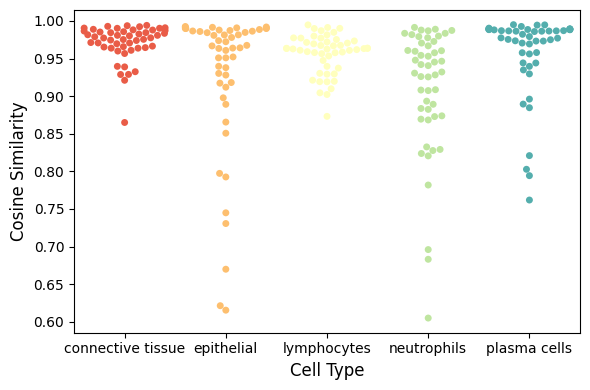

In [11]:
ct.pl.gene_similarity(reconstructed_adata, marker_df)